# Inference: No U-Turn Sampler (NUTS)

This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using [Monomial-Gamma HMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/nuts_mcmc.html).


First, we create a simple normal distribution

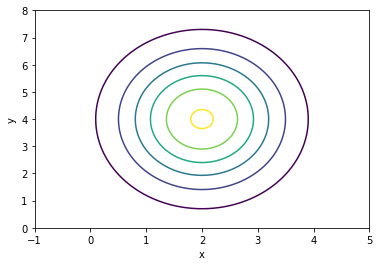

In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using NUTS MCMC.

In [2]:
# Choose starting points for 3 mcmc chains
xs = [
    [2, 1],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
sigma = [1, 1]
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.NUTSMCMC, sigma0=sigma)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [ ]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

In [ ]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

## Monomial-Gamma HMC on a time-series problem

We now try the same method on a time-series problem

In [ ]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
times = np.linspace(0, 1000, 50)
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.MonomialGammaHamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

The chains do not take long to reach equilibrium with this method.

In [ ]:
# Show traces and histograms
pints.plot.trace(chains)
plt.show()

Chains have converged!

In [ ]:
# Discard warm up
chains = chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

Extract any divergent iterations -- looks fine as there were none.

In [ ]:
div_iterations = []
for sampler in mcmc.samplers():
    div_iterations.append(sampler.divergent_iterations())
print("There were " + str(np.sum(div_iterations)) + " divergent iterations.")